##### 딥러닝 프로젝트
- 로컬 웹에 서비스 구현까지

[1] 모듈 로딩

In [1]:
import os # 파일 및 디렉토리 생성
import cv2 # 비전 처리
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
import time # 학습에 걸린 시간 기록용
import numpy as np

import torch
import torch.nn as nn 
import torchvision.transforms as transforms # 데이터 증강용
from torch.optim.lr_scheduler import ReduceLROnPlateau # 콜백함수
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary

from torch.cuda.amp import autocast, GradScaler # 학습 gpu로 돌리기 위한 cuda 모듈

[2] 학습에 필요한 함수 및 클래스 선언

In [2]:
# 시각화 - 각 데이터셋 폴더(동물) 첫 번째 이미지 확인
def show_image(path):
    image_list = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        # 이미지 불러오기 (BGR -> RGB 변환)
        image = cv2.imread(os.path.join(folder_path, os.listdir(folder_path)[0]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 이미지, 폴더이름 저장
        image_list.append([image, folder])
    
    plt.subplots(figsize = (10,10))
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image_list[i][0])
        plt.xlabel(image_list[i][1])
    plt.show()

# 사용자 정의 클래스 생성
class CNN_use_sequential(nn.Module):
    def __init__(self):
        super(CNN_use_sequential, self).__init__()
        self.layer1 = nn.Sequential( # __init__에서 사용할 네트워크 모델 정의
            nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 3, stride= 1, padding= 'same'),
            # in_channels : 입력 채널 개수. rgb 이미지라 3으로 설정
            # out_channels : 출력 채널 개수. 학습의 복잡도와 파라미터 수 결정
            # kernel_size : 컨볼루션 필터 크기
            # stride : 필터의 이동간격
            # padding : 가장자리에 추가되는 패딩의 크기. same으로 설정하여 입출력 크기 보존
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2), # 특성 맵 다운 샘플링용. 모델 계산량을 줄이고 위치 불변성은 증가

            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, stride= 1, padding= 'same'),
            nn.BatchNorm2d(64), # 각 채널 입력 정규화
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3, stride= 1, padding= 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2),

            nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size= 3, stride= 1, padding= 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3, stride= 1, padding= 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )

        # Fully connected layer => 이전 레이어 출력을 평탄화 하여 다음 스테이지에서 입력 받을 수 있게 하는 단일 벡터로 변환
        self.fc = nn.Sequential(
            nn.Linear(16384, 1024),
            nn.ReLU(),
            nn.Dropout(0.4), # 과적합 방지

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4), 

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 10),
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # Fully connected layer에 넣기 위해 텐서를 펼침
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Train 함수
def train(model, train_loader, optimizer, criterion):
    scaler = GradScaler() # 역전파때 fp32로 변경하려고 선언

    model.train()  # 학습모드 설정

    total_loss_train = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # 경사도 초기화
        if torch.cuda.is_available():
            inputs = inputs.to(torch.device('cuda'))
            labels = labels.to(torch.device('cuda'))

        with autocast(): # 학습 시 fp16으로 변경
            outputs = model(inputs)  # Forward pass

            loss_train = criterion(outputs, labels)  # Loss 계산

        loss_train.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        total_loss_train += loss_train.item() * labels.size(0) # 배치 손실 누적 
        _, predicted_train = torch.max(outputs, 1) # Predict
        correct_predictions_train += (predicted_train == labels).sum().item() # 정확한 예측 수
        total_samples_train += labels.size(0) # 총 샘플 수

        # 130번째 배치 마다 학습 진행 출력
        if (batch_idx+1) % 130 == 0:
            print('Train: [{:5}/{} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(inputs), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                total_loss_train / total_samples_train))
    
    # 학습 후 모델 저장
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, os.path.join(model_save_dir, 'model_last.pth'))
    
    # 에포크 당 평균 손실과 정확도 계산
    epoch_loss_train = total_loss_train / total_samples_train
    accuracy_train = correct_predictions_train / total_samples_train
    return epoch_loss_train, accuracy_train

# Val 함수
def val(model, valid_loader, criterion, best_valid_loss, model_save_dir):
    
    model.eval()  # 검증모드 설정

    total_loss_val = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():  # 경사도 계산 비활성화
        for inputs, labels in valid_loader:
            if torch.cuda.is_available():
                inputs = inputs.to(torch.device('cuda'))  
                labels = labels.to(torch.device('cuda'))

            outputs = model(inputs)  # Forward pass
            loss_val = criterion(outputs, labels)  # Loss 계산

            total_loss_val += loss_val.item() * labels.size(0) # 배치 손실 누적
            _, predicted_val = torch.max(outputs, 1) # 예측 결과
            correct_predictions_val += (predicted_val == labels).sum().item() # 정확한 예측 수
            total_samples_val += labels.size(0) # 총 샘플 수

        # 에포크 당 손실과 정확도 계산
        epoch_loss_val = total_loss_val / total_samples_val
        accuracy_val = correct_predictions_val / total_samples_val
    
    return epoch_loss_val, accuracy_val

# Test 함수
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
    print(f'ACCURACY ON THE TEST DATASET => {100 * accuracy:.2f}%')

# Learning curve 시각화
def learning_curve(epoch_loss_train, accuracy_train, epoch_loss_val, accuracy_val, epochs):
    plt.plot(range(epochs), epoch_loss_train, label = 'train_loss', marker = 'o')
    plt.plot(range(epochs), epoch_loss_val, label = 'val_loss', marker = '^')    
    plt.plot(range(epochs), accuracy_train, label = 'ACC_TRAIN')
    plt.plot(range(epochs), accuracy_val, label = 'ACC_VAL')
    
    plt.xticks(range(epochs))
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.tight_layout()
    plt.legend()
    plt.show()

[3] 경로 및 파라미터 설정

C:\Users\LG\AppData\Local\Temp\ipykernel_18700\1731382830.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(image_list), i+1)


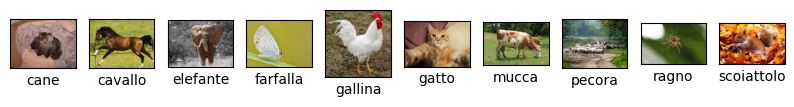

In [3]:
# 데이터셋 경로
TRAIN_PATH = '../../../LocalData/pj_08_DL/miniP/splitData/train'
VAL_PATH = '../../../LocalData/pj_08_DL/miniP/splitData/val'
TEST_PATH = '../../../LocalData/pj_08_DL/miniP/splitData/test'

# 폴더 별 첫 번째 이미지 시각화
show_image(TRAIN_PATH)

# 파라미터
TARGET_SIZE = (256, 256)
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VAL_TEST = 250
EPOCHS = 35
learning_rate = 0.001
model_save_dir = '../../../LocalData/pj_08_DL/miniP/model'
patience = 4

[4] 학습 효율 향상을 위한 데이터 증강

In [11]:
# 데이터 증강
transform_train = transforms.Compose(
    [
        transforms.Resize(TARGET_SIZE), # 이미지 크기 조절
        #transforms.RandomAutocontrast(), # 대조 조정
        #transforms.RandomAffine(degrees= 0, translate= (0.2, 0.2)), # affine 공간에서 회전, 이동
        transforms.RandomHorizontalFlip(), # 확률로 좌우반전, 확률 파라미터 디폴트는 0.5로 잡혀있음
        transforms.ToTensor()
    ]
)

transform_test_val = transforms.Compose(
    [
        transforms.Resize(TARGET_SIZE),
        transforms.ToTensor()
    ]
)

In [12]:
# 데이터 로드
#train_dataset[index_image][0] =>  image (tensor); train_dataset[index_image][1] => label (int)
train_dataset = ImageFolder(root= TRAIN_PATH, transform= transform_train)
val_dataset = ImageFolder(root= VAL_PATH, transform= transform_test_val)
test_dataset = ImageFolder(root= TEST_PATH, transform= transform_test_val)

train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE_TRAIN, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE_VAL_TEST, shuffle= False)
test_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE_VAL_TEST, shuffle= False)

#show_image_from_tensor(path_font, 32, train_dataset[5000], TARGET_SIZE[0])
print('============================== DATA ============================')
print('Train data size: {}'.format(len(train_dataset)))
print('Val data size: {}'.format(len(val_dataset)))
print('Test data size: {}'.format(len(test_dataset)))
print('================================================================')

============================== DATA ============================
Train data size: 15702
Val data size: 5236
Test data size: 5241


[5] 학습 진행

GPU
===========================   MODEL   ==========================
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        896
|    └─ReLU: 2-2                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-4                       [-1, 64, 128, 128]        18,496
|    └─BatchNorm2d: 2-5                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-6                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 64, 64]          --
├─Sequential: 1-2                        [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 64, 64]         73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 64, 64]         256
|    └─ReLU: 2-10                        [-1, 128, 64, 64]         --
|    

C:\Users\sjth0\AppData\Local\Temp\ipykernel_5616\2876150667.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\sjth0\AppData\Local\Temp\ipykernel_5616\2876150667.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train: [ 2064/15702 (13%)]	Loss: 2.400539
Train: [ 4144/15702 (26%)]	Loss: 2.300940
Train: [ 6224/15702 (40%)]	Loss: 2.262697
Train: [ 8304/15702 (53%)]	Loss: 2.244718
Train: [10384/15702 (66%)]	Loss: 2.223063
Train: [12464/15702 (79%)]	Loss: 2.212678
Train: [14544/15702 (93%)]	Loss: 2.199476
Loss train: 2.19153561736046, Acc_train: 0.2146860272576742, Loss val: 2.1357486778493144, Acc_val: 0.21867838044308632
Best loss val in epoch 1: 2.1357486778493144, Learning rate: 0.001
Total time:  169.03727769851685
EPOCH 2
Train: [ 2064/15702 (13%)]	Loss: 2.063951
Train: [ 4144/15702 (26%)]	Loss: 2.054347
Train: [ 6224/15702 (40%)]	Loss: 2.050994
Train: [ 8304/15702 (53%)]	Loss: 2.041385
Train: [10384/15702 (66%)]	Loss: 2.025928
Train: [12464/15702 (79%)]	Loss: 2.007793
Train: [14544/15702 (93%)]	Loss: 1.986401
Loss train: 1.9788204509275702, Acc_train: 0.2941663482358935, Loss val: 1.8304411103199054, Acc_val: 0.3516042780748663
Best loss val in epoch 2: 1.8304411103199054, Learning rate: 0.0

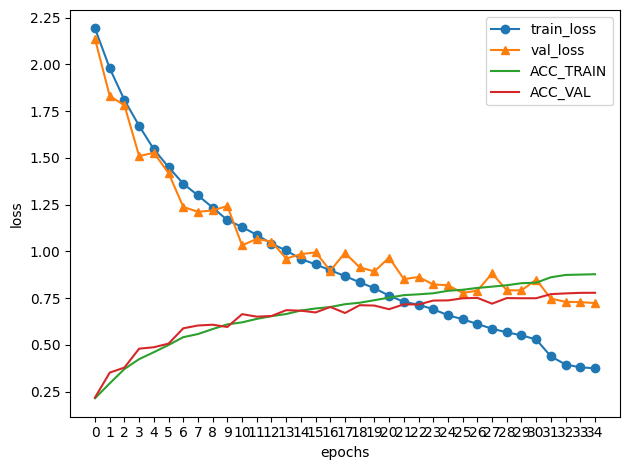

===================== EVAL IN TEST DATASET =====================


C:\Users\sjth0\AppData\Local\Temp\ipykernel_5616\3517967482.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_save_dir

ACCURACY ON THE TEST DATASET => 78.36%


In [5]:
# GPU 사용 가능 여부 확인 
if torch.cuda.is_available():
    print('GPU')
    device = torch.device("cuda")
else:
    print('CPU')
    device = torch.device("cpu")
    
# 모델 인스턴스 생성
model = CNN_use_sequential().to(device)
print('===========================   MODEL   ==========================')
print(summary(model, (3, TARGET_SIZE[0],TARGET_SIZE[0])))

# 손실함수, 옵티마이저 인스턴스 생성
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

# 학습 최적화를 위한 콜백함수 인스턴스 생성
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience= patience, min_lr=0.0000001)

best_valid_loss = float('inf') # 양의 무한대로


epochs_loss_train = []
epochs_loss_val = []
list_accuracy_train = []
list_accuracy_val = []
# 학습 / 검증 루프
print('========================== TRANNING ============================')
for epoch in range(EPOCHS):
    start_time = time.time()
    print('EPOCH {}'.format(epoch + 1))
    # Train
    epoch_loss_train, accuracy_train = train(model, train_loader, optimizer, criterion)
    # Val
    epoch_loss_val, accuracy_val = val(model, val_loader, criterion, best_valid_loss, model_save_dir)
    # learning rate 스케줄러
    scheduler.step(epoch_loss_val)
    # loss_val 최소값 저장 모델
    if epoch_loss_val < best_valid_loss:
        best_valid_loss = epoch_loss_val
        epoch_good = epoch + 1
        torch.save(model.state_dict(), model_save_dir + '/model.pth')  # 모델 웨이트만 저장

        
    endtime = time.time() - start_time
    lr = optimizer.param_groups[-1]['lr']
    print('Loss train: {}, Acc_train: {}, Loss val: {}, Acc_val: {}\nBest loss val in epoch {}: {}, Learning rate: {}'.format(epoch_loss_train, accuracy_train, epoch_loss_val, accuracy_val, epoch_good, best_valid_loss, lr))
    print('Total time: ', endtime)
    print('================================================================')
    
    epochs_loss_train.append(epoch_loss_train)
    epochs_loss_val.append(epoch_loss_val)
    list_accuracy_train.append(accuracy_train)
    list_accuracy_val.append(accuracy_val)
    
    # 에포크 끝날 때마다 GPU 메모리 정리 => gpu 돌릴 때 최적화 아웃오브메모리 오류 해결 위해서 추가
    torch.cuda.empty_cache()

# 훈련 결과 시각화
print('========================= LEARNING CURVE =======================')
learning_curve(epochs_loss_train, list_accuracy_train, epochs_loss_val, list_accuracy_val, EPOCHS)

# 테스트 데이터로 성능 검증
print('===================== EVAL IN TEST DATASET =====================')
model = CNN_use_sequential().to(device) 
model.load_state_dict(torch.load(os.path.join(model_save_dir, 'model.pth'))) # 최고 성능 weight 저장된 모델 로드
test(model, test_loader, device)